<a href="https://colab.research.google.com/github/nagaditya39/ESRGAN-ImageSR-Colab/blob/main/gan2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00


In [2]:
#utils.py

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
import re

import shutil
from google.colab import drive
from google.colab import files

def read_image(img_path):
    base=os.path.basename(img_path)
    ext = os.path.splitext(base)[1]
    assert ext in ['.png', '.jpg', '.jpeg', '.JPEG']
    image = tf.io.read_file(img_path)
    if ext == '.png':
        image = tf.image.decode_png(image, channels=3)
    else:
        image = tf.image.decode_jpeg(image, channels=3)
    return image

# def create_lr_hr_pair(img_path, scale):
#     image = read_image(img_path)
#     lr_height, lr_width = image.shape[0] // scale, image.shape[1] // scale
#     hr_height, hr_width = lr_height * scale, lr_width * scale
#     hr_image = image[:hr_height, :hr_width, :]
#     lr_shape = [lr_height, lr_width]
#     lr_image = tf.image.resize(hr_image, lr_shape, method=tf.image.ResizeMethod.BICUBIC)

#     return lr_image, hr_image

def scale_image_0_1_range(image):
    image = image / 255
    red_max = tf.reduce_max(image, axis=None)
    red_min = tf.reduce_min(image, axis=None)
    if red_max > 1 or red_min < 0:
        image = tf.clip_by_value(
            image, 0, 1, name=None
        )
    return image


# def unscale_image_0_255_range(image):
#     image = image * 255
#     red_max = tf.reduce_max(image, axis=None)
#     red_min = tf.reduce_min(image, axis=None)
#     if red_max > 255 or red_min < 0:
#         image = tf.clip_by_value(
#             image, 0, 255, name=None
#         )
#     return image

def tensor2img(tensor):
    return (np.squeeze(tensor.numpy()).clip(0, 1) * 255).astype(np.uint8)


def save_image_grid(lr, hr, ref=None, save_path=None):
    lr_title = "lr: {}".format(lr.shape)
    hr_title = "hr: {}".format(hr.shape)
    images = [lr, hr]
    titles = [lr_title, hr_title]
    if ref is not None:
        ref_title = "ref: {}".format(ref.shape)
        images += [ref]
        titles += [ref_title]
        fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))


    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img)
        axes[i].set_title(title, fontsize = 20)
        axes[i].axis('off')
    # fig.savefig(save_path, bbox_inches = 'tight', pad_inches = 0.25)
    plt.show()


def load_models_for_epoch(base_path, epoch_num, is_gan=False):
    # """Loads model(s) for a specific epoch."""
    model_path = f"{base_path}_epoch_{epoch_num}.h5"
    if not Path(model_path).exists():
        raise ValueError(f"Model for epoch {epoch_num} not found at {model_path}")
    model = tf.keras.models.load_model(model_path)
    if is_gan:  # Load discriminator as well for GAN training
        disc_path = f"{base_path.replace('esrgan', 'disc_gan')}_epoch_{epoch_num}.h5"
        discriminator = tf.keras.models.load_model(disc_path)
        return model, discriminator
    return model

def get_available_epochs(base_path):
    # """Returns a list of available epoch numbers from saved model filenames."""
    model_dir = Path(base_path).parent
    pattern = re.compile(r"_epoch_(\d+)\.h5")
    epochs = []
    for filename in model_dir.glob("*.h5"):
        match = pattern.search(filename.name)
        if match:
            epochs.append(int(match.group(1)))
    return sorted(epochs)


def download_saved_folder(saved_folder_path, download_location="local", drive_folder_id=None):
    # """Downloads the saved folder to the specified location."""

    if download_location == "local":
        # Download to local machine (assuming you are using Colab)
        shutil.make_archive(saved_folder_path, 'zip', saved_folder_path)
        zipped_filename = saved_folder_path + ".zip"
        files.download(zipped_filename)

    elif download_location == "drive" and drive_folder_id:
        # Download to Google Drive (Colab only)
        drive.mount('/content/gdrive')  # Mount Google Drive
        destination_path = "/content/gdrive/My Drive/" + drive_folder_id
        shutil.make_archive(saved_folder_path, 'zip', saved_folder_path)
        zipped_filename = saved_folder_path + ".zip"
        shutil.move(zipped_filename, destination_path)
        print(f"Saved folder uploaded to Google Drive folder ID: {drive_folder_id}")

    else:
        print(f"[!] Invalid download location or missing Drive folder ID.")

In [3]:
#metrics.py

import tensorflow as tf

def calculate_psnr(img1, img2):
    #img1 and img2 have range [0, 255]
    #psnr = 20 * np.log10(255.0 / np.sqrt(np.mean((img1 - img2)**2)))
    return tf.image.psnr(img1, img2, max_val=255)

def calculate_ssim(hr, generated_hr):
    #hr and generated_hr have range [0, 255]
    return tf.image.ssim(hr, generated_hr, max_val=255)

<ipython-input-4-c07934a7ebfc>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


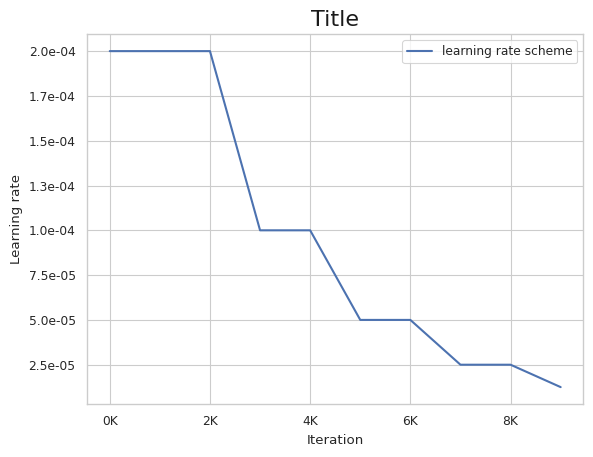

In [4]:
# lr_scheduler.py
import tensorflow as tf


def MultiStepLR(initial_learning_rate, lr_steps, lr_rate, name='MultiStepLR'):
    # """Multi-steps learning rate scheduler."""
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=lr_steps, values=lr_steps_value)


# def CosineAnnealingLR_Restart(initial_learning_rate, t_period, lr_min):
#     # """Cosine annealing learning rate scheduler with restart."""
#     return tf.keras.experimental.CosineDecayRestarts(
#         initial_learning_rate=initial_learning_rate,
#         first_decay_steps=t_period, t_mul=1.0, m_mul=1.0,
#         alpha=lr_min / initial_learning_rate)


if __name__ == "__main__":
    # pretrain PSNR lr scheduler
    lr_scheduler = MultiStepLR(2e-4, [2000, 4000, 6000, 8000], 0.5)

    # ESRGAN lr scheduler
    # lr_scheduler = MultiStepLR(1e-4, [50000, 100000, 200000, 300000], 0.5)

    # Cosine Annealing lr scheduler
    # lr_scheduler = CosineAnnealingLR_Restart(2e-4, 250000, 1e-7)

    ##############################
    # Draw figure
    ##############################

    N_iter = 10000
    step_list = list(range(0, N_iter, 1000))
    lr_list = []
    for i in step_list:
        current_lr = lr_scheduler(i).numpy()
        lr_list.append(current_lr)

    import matplotlib as mpl
    from matplotlib import pyplot as plt
    import matplotlib.ticker as mtick
    mpl.style.use('default')
    import seaborn
    seaborn.set(style='whitegrid')
    seaborn.set_context('paper')

    plt.figure(1)
    plt.subplot(111)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    plt.title('Title', fontsize=16, color='k')
    plt.plot(step_list, lr_list, linewidth=1.5, label='learning rate scheme')
    legend = plt.legend(loc='upper right', shadow=False)
    ax = plt.gca()
    labels = ax.get_xticks().tolist()
    for k, v in enumerate(labels):
        labels[k] = str(int(v / 1000)) + 'K'
    ax.set_xticklabels(labels)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

    ax.set_ylabel('Learning rate')
    ax.set_xlabel('Iteration')
    fig = plt.gcf()
    plt.show()

In [5]:
# losses.py
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19

def get_pixel_loss(criterion='l1'):
    """pixel loss"""
    if criterion == 'l1':
        return tf.keras.losses.MeanAbsoluteError()
    elif criterion == 'l2':
        return tf.keras.losses.MeanSquaredError()
    else:
        raise NotImplementedError(
            'Loss type {} is not recognized.'.format(criterion))

def get_content_loss(criterion='l1', output_layer=54, before_act=True):
    """content loss"""
    if criterion == 'l1':
        loss_func = tf.keras.losses.MeanAbsoluteError()
    elif criterion == 'l2':
        loss_func = tf.keras.losses.MeanSquaredError()
    else:
        raise NotImplementedError(
            'Loss type {} is not recognized.'.format(criterion))
    vgg = VGG19(input_shape=(None, None, 3), include_top=False, weights='imagenet')

    if output_layer == 22:  # Low level feature
        pick_layer = 5
    elif output_layer == 54:  # Hight level feature
        pick_layer = 20
    else:
        raise NotImplementedError(
            'VGG output layer {} is not recognized.'.format(criterion))

    if before_act:
        vgg.layers[pick_layer].activation = None

    fea_extrator = tf.keras.Model(vgg.input, vgg.layers[pick_layer].output)
    fea_extrator.trainable = False

    @tf.function
    def content_loss(real_hr, fake_hr):
        # the input scale range is [0, 1] (vgg is [0, 255]).
        # 12.75 is rescale factor for vgg featuremaps.
        preprocess_fake_hr = preprocess_input(fake_hr * 255.) / 12.75
        preprocess_real_hr = preprocess_input(real_hr * 255.) / 12.75
        fake_hr_features = fea_extrator(preprocess_fake_hr)
        real_hr_features = fea_extrator(preprocess_real_hr)

        return loss_func(real_hr_features, fake_hr_features)

    return content_loss

def get_discriminator_loss(gan_type='ragan'):
    """discriminator loss"""
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    sigma = tf.sigmoid

    def discriminator_loss_ragan(real_discriminator_logits, fake_discriminator_logits):
        real_logits = sigma(real_discriminator_logits - tf.reduce_mean(fake_discriminator_logits))
        fake_logits = sigma(fake_discriminator_logits - tf.reduce_mean(real_discriminator_logits))
        return 0.5 * (
            cross_entropy(tf.ones_like(real_logits), real_logits) +
            cross_entropy(tf.zeros_like(fake_logits), fake_logits))

    def discriminator_loss(real_discriminator_logits, fake_discriminator_logits):
        real_loss = cross_entropy(tf.ones_like(real_discriminator_logits), sigma(real_discriminator_logits))
        fake_loss = cross_entropy(tf.zeros_like(fake_discriminator_logits), sigma(fake_discriminator_logits))
        return real_loss + fake_loss

    if gan_type == 'ragan':
        return discriminator_loss_ragan
    elif gan_type == 'gan':
        return discriminator_loss
    else:
        raise NotImplementedError(
            'Discriminator loss type {} is not recognized.'.format(gan_type))

def get_generator_loss(gan_type='ragan'):
    """generator loss"""
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    sigma = tf.sigmoid

    def generator_loss_ragan(real_discriminator_logits, fake_discriminator_logits):
        real_logits = sigma(real_discriminator_logits - tf.reduce_mean(fake_discriminator_logits))
        fake_logits = sigma(fake_discriminator_logits - tf.reduce_mean(real_discriminator_logits))
        return 0.5 * (
            cross_entropy(tf.ones_like(fake_logits), fake_logits) +
            cross_entropy(tf.zeros_like(real_logits), real_logits))

    def generator_loss(real_discriminator_logits, fake_discriminator_logits):
        return cross_entropy(tf.ones_like(fake_discriminator_logits), sigma(fake_discriminator_logits))

    if gan_type == 'ragan':
        return generator_loss_ragan
    elif gan_type == 'gan':
        return generator_loss
    else:
        raise NotImplementedError(
            'Generator loss type {} is not recognized.'.format(gan_type))

In [6]:
# dataset.py

import os
import random
import tensorflow as tf
import numpy as np


DATA_PATH = "/content/HR"

def scale_input_image(img):
    #img/ 255.
    return tf.image.convert_image_dtype(img, dtype=tf.float32)

# def unscale_output_image(img):
#     #img * 255
#     return tf.image.convert_image_dtype(img, dtype=tf.uint8, saturate=True)

def random_crop_and_flip(img, random_crop_size):
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    image = img[y:(y+dy), x:(x+dx), :]
    flip_case = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    if(tf.equal(flip_case, 0)):
        image = tf.image.flip_left_right(image)
    return image

def load_and_preprocess_image(image_path, hr_height, hr_width, crop_per_image, ext):
    assert ext in ['.png', '.jpg', '.jpeg', '.JPEG']
    image = tf.io.read_file(image_path)
    if ext == '.png':
        image = tf.image.decode_png(image, channels=3)
    else:
        image = tf.image.decode_jpeg(image, channels=3)

    image = scale_input_image(image)
    cropped_images = [ random_crop_and_flip(image, (hr_height, hr_width)) for _ in range(crop_per_image)]

    return cropped_images



def load_dataset(hr_height, hr_width, scale, crop_per_image=20, ext='.png'):
    image_paths = []
    for root, _, files in os.walk(DATA_PATH):
        for file in files:
            if f'{ext}' in file:
                image_paths.append(os.path.join(root, file))

    random.shuffle(image_paths)
    images = []
    for img_path in image_paths:
        images += load_and_preprocess_image(img_path, hr_height, hr_width, crop_per_image, ext)

    random.shuffle(images)
    hr_images = []
    lr_images = []
    for img in images:
        hr_image = img
        lr_shape = [int(hr_image.shape[0]/scale), int(hr_image.shape[1]/scale)]
        lr_image = tf.image.resize(hr_image, lr_shape, method=tf.image.ResizeMethod.BICUBIC)
        #lr_image = lr_image / 255
        lr_image = tf.clip_by_value(
        lr_image, 0, 1, name=None
        )
        hr_images.append(hr_image)
        lr_images.append(lr_image)

    lr_dataset = tf.data.Dataset.from_tensor_slices(lr_images)
    hr_dataset = tf.data.Dataset.from_tensor_slices(hr_images)

    dataset = tf.data.Dataset.zip((lr_dataset, hr_dataset))

    return dataset





In [7]:
# esrgan.py
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, PReLU, Dropout, Dense
from tensorflow.keras.layers import BatchNormalization, Concatenate, Lambda, Add


def residual_dense_block(input, filters):
    x1 = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(input)
    x1 = LeakyReLU(0.2)(x1)
    x1 = Concatenate()([input, x1])

    x2 = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x1)
    x2 = LeakyReLU(0.2)(x2)
    x2 = Concatenate()([input, x1, x2])

    x3 = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x2)
    x3 = LeakyReLU(0.2)(x3)
    x3 = Concatenate()([input, x1, x2, x3])

    x4 = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x3)
    x4 = LeakyReLU(0.2)(x4)
    x4 = Concatenate()([input, x1, x2, x3, x4])

    x5 = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x4)
    x5 = Lambda(lambda x: x * 0.2)(x5)
    x = Add()([x5, input])

    return x

def rrdb(input, filters):
    x = residual_dense_block(input, filters)
    x = residual_dense_block(x, filters)
    x = residual_dense_block(x, filters)
    x = Lambda(lambda x: x * 0.2)(x)
    out = Add()([x, input])
    return out

def sub_pixel_conv2d(scale_factor=2, **kwargs):
    return Lambda(lambda  x: tf.nn.depth_to_space(x, scale_factor), **kwargs)

def upsample(input_tensor, filters, scale_factor=2):
    x = Conv2D(filters=filters*4, kernel_size=3, strides=1, padding='same')(input_tensor)
    x = sub_pixel_conv2d(scale_factor=scale_factor)(x)
    x = PReLU(shared_axes=[1,2])(x)
    return x

def rrdb_net(input_shape=(None, None, 3), filters=64, scale_factor=4, name='RRDB_model'):
    lr_image = Input(shape=input_shape, name='input')

    #Pre-residual
    x_start = Conv2D(filters, kernel_size=3, strides=1, padding='same')(lr_image)
    x_start = LeakyReLU(0.2)(x_start)

    #Residual block
    x = rrdb(x_start, filters)

    #Post Residual block
    x = Conv2D(filters,  kernel_size=3, strides=1, padding='same')(x)
    x = Lambda(lambda x: x * 0.2)(x)
    x = Add()([x, x_start])

    #Upsampling
    x = upsample(x, filters, scale_factor)

    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    out = Conv2D(filters=3, kernel_size=3, strides=1, padding='same')(x)

    return Model(inputs=lr_image, outputs=out, name=name)

def conv2d_block(input, filters, strides=1, bn=True):
    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(input)
    x = LeakyReLU(0.2)(x)
    if bn:
        x = BatchNormalization(momentum=0.8)(x)
    return x


def discriminator_net(input_shape=(None, None, 3), filters=64, name='Discriminator'):
    img = Input(shape=input_shape)

    x = conv2d_block(img, filters, bn=False)
    x = conv2d_block(x, filters, strides=2)
    x = conv2d_block(x, filters*2)
    x = conv2d_block(x, filters*2, strides=2)
    x = conv2d_block(x, filters*4)
    x = conv2d_block(x, filters*4, strides=2)
    x = conv2d_block(x, filters*8)
    x = conv2d_block(x, filters*8, strides=2)
    x = Dense(filters*16)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    x = Dense(1)(x)

    return Model(inputs=img, outputs=x, name=name)


In [8]:
#train_psnr.py

import json
import sys
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
# from modules.esrgan import rrdb_net
# from modules.lr_scheduler import MultiStepLR
# from modules.data import load_dataset
# from modules.losses import get_pixel_loss

HAS_WANDB_ACCOUNT = False
PROJECT = 'esrgan-tf2'
import wandb
if not HAS_WANDB_ACCOUNT:
    wandb.login(anonymous='allow')
else:
    wandb.login()

INITIAL_LR = 2e-4
LR_RATE = 0.5
LR_STEPS = [2000, 4000, 6000, 8000]
ADAM_BETA1_G = 0.9
ADAM_BETA2_G = 0.99
W_PIXEL = 1.0
PIXEL_CRITERION = 'l1'

HR_HEIGHT = 128
HR_WIDTH = 128
SCALE = 4
BATCH_SIZE = 16
BUFFER_SIZE = 10240
INPUT_SHAPE=(None, None, 3)

NUM_ITER = 10000
SAVE_STEPS = 500


CHECK_POINT_PATH =  "./saved/checkpoints/psnr"
Path(CHECK_POINT_PATH).mkdir(parents=True, exist_ok=True)
SAVE_MODEL_PATH = "./saved/models/psnr.h5"
Path(SAVE_MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)

def main():

    num_epochs = 0




    dataset = load_dataset(HR_HEIGHT, HR_WIDTH, SCALE)
    leng= len(dataset)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

    model = rrdb_net(input_shape=INPUT_SHAPE,scale_factor=SCALE)
    learning_rate = MultiStepLR(INITIAL_LR, LR_STEPS, LR_RATE)
    optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate,
                                        beta_1= ADAM_BETA1_G,
                                        beta_2= ADAM_BETA2_G
                                        )
    pixel_loss = get_pixel_loss(PIXEL_CRITERION)

    checkpoint = tf.train.Checkpoint(step=tf.Variable(0, name='step'),
                                     optimizer=optimizer,
                                     model=model,
                                     learning_rate=learning_rate)
    manager = tf.train.CheckpointManager(checkpoint=checkpoint,
                                         directory=CHECK_POINT_PATH,
                                         max_to_keep=3)
    if manager.latest_checkpoint:
        checkpoint.restore(manager.latest_checkpoint)
        print('[*] load ckpt from {} at step {}.'.format(
            manager.latest_checkpoint, checkpoint.step.numpy()))

      # Load configurations from JSON
        config_load_path = f"configs_step_{int(checkpoint.step.numpy())}.json"
        with open(config_load_path, 'r') as f:
            configs = json.load(f)

        # Update learning rate and other configurations if needed
        global HR_HEIGHT, HR_WIDTH, SCALE, BATCH_SIZE, BUFFER_SIZE
        INITIAL_LR = configs["INITIAL_LR"]
        LR_RATE = configs["LR_RATE"]
        LR_STEPS = configs["LR_STEPS"]
        ADAM_BETA1_G: configs["ADAM_BETA1_G"]
        ADAM_BETA2_G: configs["ADAM_BETA2_G"]
        W_PIXEL: configs["W_PIXEL"]
        PIXEL_CRITERION: configs["PIXEL_CRITERION"]
        HR_HEIGHT: configs["HR_HEIGHT"]
        HR_WIDTH: configs["HR_WIDTH"]
        SCALE: configs["SCALE"]
        BATCH_SIZE: configs["BATCH_SIZE"]
        BUFFER_SIZE: configs["BUFFER_SIZE"]

        # Recreate learning rate scheduler (if necessary)
        learning_rate = MultiStepLR(INITIAL_LR, LR_STEPS, LR_RATE)
        optimizer.learning_rate = learning_rate  # Update optimizer's learning rate

    else:
        print("[*] Training from scratch.")




    @tf.function
    def train_step(lr, hr):
        with tf.GradientTape() as tape:
            generated_hr = model(lr, training=True)
            loss = W_PIXEL * pixel_loss(hr, generated_hr)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        return loss

    wandb_run_id = "psnr-training" #@param {type:"string"}
    if HAS_WANDB_ACCOUNT:
        wandb.init(entity='ilab', project=PROJECT, id=wandb_run_id)
    else:
        wandb.init(id=wandb_run_id)

    remain_steps = max(NUM_ITER - checkpoint.step.numpy(), 0)
    pbar = tqdm(total=remain_steps, ncols=50)

    available_epochs = get_available_epochs(SAVE_MODEL_PATH)
    if available_epochs:
        print("Available epochs:", available_epochs)
        resume_epoch = int(input("Enter epoch to resume from (or 0 to start fresh): "))
    else:
        resume_epoch = 0  # No saved models found, start fresh

    if resume_epoch > 0:
        # Load model for the specified epoch
        model = load_models_for_epoch(SAVE_MODEL_PATH, resume_epoch)
        # Update the starting step based on the chosen epoch
        checkpoint.step.assign(resume_epoch * leng)
        print(f"[*] Resuming training from epoch {resume_epoch}")


    for lr, hr in dataset.take(remain_steps):
        checkpoint.step.assign_add(1)
        steps = checkpoint.step.numpy()
        loss = train_step(lr, hr)
        learning_rate = optimizer.lr.numpy()  # Get the learning rate value
        wandb.log({"steps": steps, "loss": loss, "learning_rate": learning_rate})
        pbar.set_description("loss={:.4f}, lr={:.1e}".format(loss, learning_rate))
        pbar.update()
        # sys.stdout.flush()

        if steps % SAVE_STEPS == 0:
            manager.save()
            print("\n[*] save ckpt file at {}".format(manager.latest_checkpoint))

            configs = {
            "INITIAL_LR": INITIAL_LR,
            "LR_RATE": LR_RATE,
            "LR_STEPS": LR_STEPS,
            "ADAM_BETA1_G": ADAM_BETA1_G,
            "ADAM_BETA2_G": ADAM_BETA2_G,
            "W_PIXEL": W_PIXEL,
            "PIXEL_CRITERION": PIXEL_CRITERION,
            "HR_HEIGHT": HR_HEIGHT,
            "HR_WIDTH": HR_WIDTH,
            "SCALE": SCALE,
            "BATCH_SIZE": BATCH_SIZE,
            "BUFFER_SIZE": BUFFER_SIZE,
            }


          # Save configurations as JSON
            config_save_path = f"configs_step_{steps}.json"
            with open(config_save_path, 'w') as f:
                json.dump(configs, f, indent=4)
            print(f"[*] Saved configurations as {config_save_path}")

        num_epochs +=1
        if num_epochs % 1000 == 0:
          model_save_path = f"{SAVE_MODEL_PATH}_epoch_{num_epochs}.h5"
          model.save(model_save_path)
          print(f"\n[*] Saved model as {model_save_path}")

          # Save configurations as a JSON file
          config_save_path = f"configs_epoch_{num_epochs}.json"
          with open(config_save_path, 'w') as f:
              json.dump(configs, f, indent=4)
          print(f"[*] Saved configurations as {config_save_path}")


          download_saved_folder(saved_folder_path="saved", download_location="local")
          # files.download("saved.zip")

    model.save(SAVE_MODEL_PATH)



















if __name__ == '__main__':
    main()

<IPython.core.display.Javascript object>

wandb: (1) Private W&B dashboard, no account required
wandb: (2) Use an existing W&B account


wandb: Enter your choice: 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


UnboundLocalError: local variable 'HR_HEIGHT' referenced before assignment

In [ ]:
# train_esrgan.py

from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
# from modules.esrgan import rrdb_net, discriminator_net
# from modules.lr_scheduler import MultiStepLR
# from modules.data import load_dataset
# from modules.losses import get_pixel_loss, get_content_loss
# from modules.losses import get_discriminator_loss, get_generator_loss

HAS_WANDB_ACCOUNT = False
PROJECT = 'esrgan-tf2'
import wandb
if not HAS_WANDB_ACCOUNT:
    wandb.login(anonymous='allow')
else:
    wandb.login()

INITIAL_LR_G = 1e-4
INITIAL_LR_D = 1e-4
LR_RATE = 0.5
LR_STEPS = [5000, 10000, 20000, 30000]
ADAM_BETA1_G = 0.9
ADAM_BETA2_G = 0.99
ADAM_BETA1_D = 0.9
ADAM_BETA2_D = 0.99

PIXEL_CRITERION = 'l1'
FEATURE_CRITERION = 'l2'
GAN_TYPE = 'ragan'
WEIGHT_PIXEL = 1e-2
WEIGHT_FEATURE = 1.0
WEIGHT_GAN = 5e-3

HR_HEIGHT = 128
HR_WIDTH = 128
SCALE = 4
BATCH_SIZE = 16
BUFFER_SIZE = 10240
INPUT_SHAPE=(None, None, 3)

NUM_ITER = 40000
SAVE_STEPS =  500

PRETRAIN_PATH =  "./saved/checkpoints/psnr"
CHECK_POINT_PATH =  "./saved/checkpoints/esrgan"
Path(CHECK_POINT_PATH).mkdir(parents=True, exist_ok=True)
SAVE_GAN_PATH = "./saved/models/esrgan.h5"
Path(SAVE_GAN_PATH).parent.mkdir(parents=True, exist_ok=True)
SAVE_DISC_PATH = "./saved/models/disc_gan.h5"
Path(SAVE_DISC_PATH).parent.mkdir(parents=True, exist_ok=True)


def main():

    num_epochs = 0

    dataset = load_dataset(HR_HEIGHT, HR_WIDTH, SCALE)
    leng = len(dataset)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

    generator = rrdb_net(input_shape=INPUT_SHAPE,scale_factor=SCALE)
    discriminator = discriminator_net(input_shape=INPUT_SHAPE)

    learning_rate_G = MultiStepLR(INITIAL_LR_G, LR_STEPS, LR_RATE)
    learning_rate_D = MultiStepLR(INITIAL_LR_D, LR_STEPS, LR_RATE)
    optimizer_G = tf.keras.optimizers.Adam(learning_rate= learning_rate_G,
                                        beta_1= ADAM_BETA1_G,
                                        beta_2= ADAM_BETA2_G
                                        )
    optimizer_D = tf.keras.optimizers.Adam(learning_rate= learning_rate_D,
                                        beta_1= ADAM_BETA1_D,
                                        beta_2= ADAM_BETA2_D
                                        )

    pixel_loss = get_pixel_loss(PIXEL_CRITERION)
    feature_loss = get_content_loss(FEATURE_CRITERION)
    generator_loss = get_generator_loss(GAN_TYPE)
    discriminator_loss = get_discriminator_loss(GAN_TYPE)

    checkpoint = tf.train.Checkpoint(step=tf.Variable(0, name='step'),
                                     optimizer_G=optimizer_G,
                                     optimizer_D=optimizer_D,
                                     model=generator,
                                     discriminator=discriminator)
    manager = tf.train.CheckpointManager(checkpoint=checkpoint,
                                         directory=CHECK_POINT_PATH,
                                         max_to_keep=3)
    if manager.latest_checkpoint:
        checkpoint.restore(manager.latest_checkpoint)
        print('[*] load ckpt from {} at step {}.'.format(
            manager.latest_checkpoint, checkpoint.step.numpy()))
    else:
        if tf.train.latest_checkpoint(PRETRAIN_PATH):
            checkpoint.restore(tf.train.latest_checkpoint(PRETRAIN_PATH))
            checkpoint.step.assign(0)
            print("[*] training from pretrain model {}.".format(
                    PRETRAIN_PATH ))
        else:
            print("[*] cannot find pretrain model {}.".format(
                PRETRAIN_PATH))

    @tf.function
    def train_step(lr, hr):
        with tf.GradientTape(persistent=True) as tape:
            generated_hr = generator(lr, training=True)
            real_logits = discriminator(hr, training=True)
            fake_logits = discriminator(generated_hr, training=True)
            losses_G = {}
            losses_D = {}
            losses_G['pixel'] = WEIGHT_PIXEL * pixel_loss(hr, generated_hr)
            losses_G['feature'] = WEIGHT_FEATURE * feature_loss(hr, generated_hr)
            losses_G['gan'] = WEIGHT_GAN * generator_loss(real_logits, fake_logits)
            losses_D['disc'] = discriminator_loss(real_logits, fake_logits)
            total_loss_G = tf.add_n([l for l in losses_G.values()])
            total_loss_D = tf.add_n([l for l in losses_D.values()])


        grads_G = tape.gradient(
            total_loss_G, generator.trainable_variables)
        grads_D = tape.gradient(
            total_loss_D, discriminator.trainable_variables)
        optimizer_G.apply_gradients(
            zip(grads_G, generator.trainable_variables))
        optimizer_D.apply_gradients(
            zip(grads_D, discriminator.trainable_variables))

        return total_loss_G, total_loss_D, losses_G, losses_D


    wandb_run_id = "esrgan-training" #@param {type:"string"}
    if HAS_WANDB_ACCOUNT:
        wandb.init(entity='ilab', project=PROJECT, id=wandb_run_id)
    else:
        wandb.init(id=wandb_run_id)
    remain_steps = max(NUM_ITER - checkpoint.step.numpy(), 0)
    pbar = tqdm(total=remain_steps, ncols=50)

# Get available epochs and prompt user for epoch to resume from
    available_epochs = get_available_epochs(SAVE_GAN_PATH)
    if available_epochs:
        print("Available epochs:", available_epochs)
        resume_epoch = int(input("Enter epoch to resume from (or 0 to start fresh): "))
    else:
        resume_epoch = 0  # No saved models found, start fresh

    if resume_epoch > 0:
        # Load models for the specified epoch
        generator, discriminator = load_models_for_epoch(SAVE_GAN_PATH, resume_epoch, is_gan=True)
        # Update the starting step based on the chosen epoch
        checkpoint.step.assign(resume_epoch * leng)
        print(f"[*] Resuming training from epoch {resume_epoch}")


    for lr, hr in dataset.take(remain_steps):
        checkpoint.step.assign_add(1)
        steps = checkpoint.step.numpy()
        total_loss_G, total_loss_D, losses_G, losses_D = train_step(lr, hr)
        learning_rate_G = optimizer_G.lr.numpy()
        learning_rate_D = optimizer_D.lr.numpy()
        wandb.log({**{"steps": steps},**losses_G, **losses_D,
                    **{"total_loss_G": total_loss_G.numpy()},
                    **{"learning_rate_G": learning_rate_G,
                    "learning_rate_D": learning_rate_D}})

        pbar.set_description("loss_G={:.4f}, loss_D={:.4f}, lr_G={:.1e}, lr_D={:.1e}".format(
            total_loss_G.numpy(), total_loss_D.numpy(),
            learning_rate_G, learning_rate_D))
        pbar.update()
        if steps % SAVE_STEPS == 0:
            manager.save()
            print("\n[*] save ckpt file at {}".format(manager.latest_checkpoint))

        num_epochs += 1
        if num_epochs % 1000 == 0:
            generator_save_path = f"{SAVE_GAN_PATH}_epoch_{num_epochs}.h5"
            discriminator_save_path = f"{SAVE_DISC_PATH}_epoch_{num_epochs}.h5"
            generator.save(generator_save_path)
            discriminator.save(discriminator_save_path)
            print(f"\n[*] Saved models at epoch {num_epochs}")
            download_saved_folder(saved_folder_path="saved", download_location="local")

    generator.save(SAVE_GAN_PATH)
    discriminator.save(SAVE_DISC_PATH)












if __name__ == '__main__':
    main()

In [ ]:
# net_interp.py

from pathlib import Path
import tensorflow as tf
# from modules.esrgan import rrdb_net


SCALE = 4
INPUT_SHAPE=(None, None, 3)
ALPHA = 0.8

CHECKPOINT_PATH_PSNR = "./saved/checkpoints/psnr"
CHECKPOINT_PATH_ESRGAN = "./saved/checkpoints/esrgan"
SAVE_MODEL_PATH = "./saved/models/interp_esr.h5"
Path(SAVE_MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)

def main():

    # define network
    model = rrdb_net(input_shape=INPUT_SHAPE,scale_factor=SCALE)

    # load checkpoint
    checkpoint_psnr = tf.train.Checkpoint(model=model)
    if tf.train.latest_checkpoint(CHECKPOINT_PATH_PSNR):
        status = checkpoint_psnr.restore(tf.train.latest_checkpoint(CHECKPOINT_PATH_PSNR))
        status.expect_partial()
        print("[*] load ckpt psnr from {}.".format(
            tf.train.latest_checkpoint(CHECKPOINT_PATH_PSNR)))
    else:
        print("[*] Cannot find ckpt psnr from {}.".format(
            tf.train.latest_checkpoint(CHECKPOINT_PATH_PSNR)))
        exit()
    vars_psnr = [v.numpy() for v in checkpoint_psnr.model.trainable_variables]

    checkpoint_esrgan = tf.train.Checkpoint(model=model)
    if tf.train.latest_checkpoint(CHECKPOINT_PATH_ESRGAN):
        status = checkpoint_esrgan.restore(tf.train.latest_checkpoint(CHECKPOINT_PATH_ESRGAN))
        status.expect_partial()
        print("[*] load ckpt edsr from {}.".format(
            tf.train.latest_checkpoint(CHECKPOINT_PATH_ESRGAN)))
    else:
        print("[*] Cannot find ckpt edsr from {}.".format(
            tf.train.latest_checkpoint(CHECKPOINT_PATH_ESRGAN)))
        exit()
    vars_edsr = [v.numpy() for v in checkpoint_esrgan.model.trainable_variables]

    # network interpolation
    for i, var in enumerate(model.trainable_variables):
        var.assign((1 - ALPHA) * vars_psnr[i] + ALPHA * vars_edsr[i])

    model.save(SAVE_MODEL_PATH)




if __name__ == '__main__':
    main()



In [ ]:
#demo.py (esrgan evaluate)

import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import load_model
# from modules.esrgan import rrdb_net
# from modules.utils import read_image, scale_image_0_1_range, tensor2img
# from modules.utils import save_image_grid



SCALE = 4
INPUT_SHAPE=(None, None, 3)

FROM_CHECKPOINT = True
#MODEL_PATH = "./saved/models/psnr.h5"
MODEL_PATH = "./saved/models/esrgan.h5"
#CHECKPOINT_PATH = "./saved/checkpoints/psnr"
CHECKPOINT_PATH = "./saved/checkpoints/esrgan"

IMG_DIR = "./images/input"  # Path to the directory containing LR images
GT_DIR = "./images/ground_truth"  # Path to the directory containing ground truth HR images (optional)
SAVE_DIR = "./images/results"  # Directory to save the upscaled images

Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

def main():

    model = rrdb_net(input_shape=INPUT_SHAPE,scale_factor=SCALE)

    checkpoint = tf.train.Checkpoint(model=model)

    if tf.train.latest_checkpoint(CHECKPOINT_PATH) and FROM_CHECKPOINT:
            status = checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_PATH))
            status.expect_partial()  # Add this line to suppress warnings
            print("[*] load ckpt from {}.".format(
            tf.train.latest_checkpoint(CHECKPOINT_PATH)))
    else:
        if os.path.isfile(MODEL_PATH):
            h5_model = load_model(MODEL_PATH, custom_objects={'tf': tf})
            weights = h5_model.get_weights()
            model.set_weights(weights)
            print("[*] load model weights from {}.".format(
            MODEL_PATH))
        else:
            print("[*] Cannot find ckpt or h5 model file.")
            exit()

    if os.path.isdir(IMG_DIR):  # Check if it's a directory
        for img_path in glob.glob(os.path.join(IMG_DIR, "*.png")):  # Assuming PNG images
            # Extract filename without extension
            filename = os.path.splitext(os.path.basename(img_path))[0]

             # Load LR image
            lr_image = read_image(img_path)
            lr_image = scale_image_0_1_range(lr_image)
            lr_image = tf.expand_dims(lr_image, axis=0)

            base_filename = filename[2:]

            # Load ground truth HR image (if available)
            hr_filename = f"hr{base_filename}.png"  # Add "hr" prefix and extension
            hr_img_path = os.path.join(GT_DIR, hr_filename)
            if os.path.exists(hr_img_path):
                hr_image = read_image(hr_img_path)
            else:
                hr_image = None

            # Generate HR image
            generated_hr = model(lr_image)
            generated_hr_image = tensor2img(generated_hr)
            unscale_lr_image = tensor2img(lr_image)

            # Calculate metrics (if ground truth is available)
            if hr_image is not None:
                psnr = calculate_psnr(hr_image, generated_hr_image)
                ssim = calculate_ssim(hr_image, generated_hr_image)
                print(f"[***] Image: {filename}, PSNR: {psnr}, SSIM: {ssim}")

            # Save image grid with LR, generated HR, and optionally ground truth
            save_path = os.path.join(SAVE_DIR, f"{filename}_upscaled.png")
            save_image_grid(unscale_lr_image, generated_hr_image, hr_image, save_path=save_path)

    else:
        print(f"[!] Invalid image directory: {IMG_DIR}")



if __name__ == '__main__':
    main()



In [ ]:
#test.py (interp_esr)

import os
import glob

from PIL import Image
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import load_model
# from modules.esrgan import rrdb_net
# from modules.utils import create_lr_hr_pair, scale_image_0_1_range, tensor2img
# from modules.utils import save_image_grid
# from modules.metrics import calculate_psnr, calculate_ssim


SCALE = 4
INPUT_SHAPE=(None, None, 3)

FROM_CHECKPOINT = False
#MODEL_PATH = "./saved/models/psnr.h5"
# MODEL_PATH = "./saved/models/esrgan.h5"
MODEL_PATH = "./saved/models/interp_esr.h5"
#CHECKPOINT_PATH = "./saved/checkpoints/psnr"
CHECKPOINT_PATH = "./saved/checkpoints/esrgan"

IMG_DIR = "./images/input"  # Path to the directory containing LR images
GT_DIR = "./images/ground_truth"  # Path to the directory containing ground truth HR images
SAVE_DIR = "./images/results"  # Directory to save the upscaled images

Path(SAVE_DIR).parent.mkdir(parents=True, exist_ok=True)

def main():

    model = rrdb_net(input_shape=INPUT_SHAPE,scale_factor=SCALE)

    checkpoint = tf.train.Checkpoint(model=model)
    if tf.train.latest_checkpoint(CHECKPOINT_PATH) and FROM_CHECKPOINT:
        checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_PATH))
        print("[*] load ckpt from {}.".format(
            tf.train.latest_checkpoint(CHECKPOINT_PATH)))
    else:
        if os.path.isfile(MODEL_PATH):
            h5_model = load_model(MODEL_PATH, custom_objects={'tf': tf})
            weights = h5_model.get_weights()
            model.set_weights(weights)
            print("[*] load model weights from {}.".format(
            MODEL_PATH))
        else:
            print("[*] Cannot find ckpt or h5 model file.")
            exit()

    if os.path.isdir(IMG_DIR):  # Check if it's a directory
        for img_path in glob.glob(os.path.join(IMG_DIR, "*.png")):  # Assuming PNG images
            # Extract filename without extension
            filename = os.path.splitext(os.path.basename(img_path))[0]

            # Load LR image
            lr_image = read_image(img_path)
            lr_image = scale_image_0_1_range(lr_image)
            lr_image = tf.expand_dims(lr_image, axis=0)

            base_filename = filename[2:]

            # Load ground truth HR image
            hr_filename = f"hr{base_filename}.png"  # Add "hr" prefix and extension
            hr_img_path = os.path.join(GT_DIR, hr_filename)
            hr_image = read_image(hr_img_path)


            # Generate HR image
            generated_hr = model(lr_image)
            generated_hr_image = tensor2img(generated_hr)
            unscale_lr_image = tensor2img(lr_image)

            # Calculate metrics
            psnr = calculate_psnr(hr_image, generated_hr_image)
            ssim = calculate_ssim(hr_image, generated_hr_image)
            print(f"[***] Image: {filename}, PSNR: {psnr}, SSIM: {ssim}")

            # Save image grid
            save_path = os.path.join(SAVE_DIR, f"{filename}_upscaled.png")
            save_image_grid(unscale_lr_image, generated_hr_image,  hr_image)

    else:
        print(f"[!] Invalid image directories: {IMG_DIR}")

















if __name__ == '__main__':
    main()

In [ ]:
# !pip install zipfile
# import os
# import zipfile
# from google.colab import files

# def zip_folder(folder_path, output_path):
#     """Zip the contents of an entire folder (with that folder included
#     in the archive). Empty subfolders will be included in the archive
#     as well.
#     """
#     parent_folder = os.path.dirname(folder_path)
#     # Retrieve the paths of the folder contents.
#     contents = os.walk(folder_path)
#     try:
#         zip_file = zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED)
#         for root, folders, files in contents:
#             # Include all subfolders, including empty ones.
#             for folder_name in folders:
#                 absolute_path = os.path.join(root, folder_name)
#                 relative_path = absolute_path.replace(parent_folder + '/', '')
#                 print("Adding {} to archive.".format(absolute_path))
#                 zip_file.write(absolute_path, relative_path)
#             for file_name in files:
#                 absolute_path = os.path.join(root, file_name)
#                 relative_path = absolute_path.replace(parent_folder + '/', '')
#                 print("Adding {} to archive.".format(absolute_path))
#                 zip_file.write(absolute_path, relative_path)
#         print("'{0}' created successfully.".format(output_path))
#     except IOError as message:
#         print(message)
#         sys.exit(1)
#     except OSError as message:
#         print(message)
#         sys.exit(1)
#     finally:
#         zip_file.close()

# zip_folder("saved", "saved.zip")

# files.download("saved.zip")